<a href="https://colab.research.google.com/github/utyug/FinRL-Library/blob/utyug_dev/FinRL_single_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Single Stock Trading

Tutorials to use OpenAI DRL to trade single stock in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-single-stock-trading-37d6d7c30aac
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 




## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: single stock trading for AAPL


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.

We use Apple Inc. stock: AAPL as an example throughout this article, because it is one of the most popular and profitable stocks.

<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
# !pip install git+https://github.com/utyug/FinRL-Library.git@utyug_dev


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

import sys
sys.path.append("../FinRL-Library")


In [3]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [6]:
# from config.py end_date is a string
config.END_DATE

'2020-12-01'

ticker_list is a list of stock tickers, in a single stock trading case, the list contains only 1 ticker

In [7]:
ticker = 'MSFT'

In [72]:
data_df = YahooDownloader(start_date = '2009-01-01',
                          end_date = '2021-01-01',
                          ticker_list = ['MSFT','SPY']).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (6042, 7)


In [36]:
# Download and save the data in a pandas DataFrame:
data_df = YahooDownloader(start_date = '2009-01-01',
                          end_date = '2021-01-01',
                          ticker_list = ['MSFT']).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3021, 7)


In [37]:
data_df.shape

(3021, 7)

In [39]:
data_df

,date,open,high,low,close,volume,tic
0,2009-01-02,19.530001,20.400000,19.370001,15.471161,50084000,MSFT
1,2009-01-05,20.200001,20.670000,20.059999,15.615757,61475200,MSFT
2,2009-01-06,20.750000,21.000000,20.610001,15.798391,58083400,MSFT
3,2009-01-07,20.190001,20.290001,19.480000,14.847140,72709900,MSFT
4,2009-01-08,19.629999,20.190001,19.549999,15.311348,70255400,MSFT
...,...,...,...,...,...,...,...
3016,2020-12-24,221.419998,223.610001,221.199997,222.750000,10550600,MSFT
3017,2020-12-28,224.449997,226.029999,223.020004,224.960007,17933500,MSFT
3018,2020-12-29,226.309998,227.179993,223.580002,224.149994,17403200,MSFT
3019,2020-12-30,225.229996,225.630005,221.470001,221.679993,20272300,MSFT


<a id='3'></a>
# Part 4. Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* FinRL uses a class **FeatureEngineer** to preprocess the data
* Add **technical indicators**. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc.


class FeatureEngineer:
Provides methods for preprocessing the stock price data

    Attributes
    ----------
        df: DataFrame
            data downloaded from Yahoo API
        feature_number : int
            number of features we used
        use_technical_indicator : boolean
            we technical indicator or not
        use_turbulence : boolean
            use turbulence index or not

    Methods
    -------
    preprocess_data()
        main method to do the feature engineering

<a id='3.1'></a>

## 4.1 Technical Indicators
* FinRL uses stockstats to calcualte technical indicators such as **Moving Average Convergence Divergence (MACD)**, **Relative Strength Index (RSI)**, **Average Directional Index (ADX)**, **Commodity Channel Index (CCI)** and other various indicators and stats.
* **stockstats**: supplies a wrapper StockDataFrame based on the **pandas.DataFrame** with inline stock statistics/indicators support.



In [40]:
## we store the stockstats technical indicator column names in config.py
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST
print(tech_indicator_list)

['macd', 'rsi_30', 'cci_30', 'dx_30']


In [41]:
## user can add more technical indicators
## check https://github.com/jealous/stockstats for different names
tech_indicator_list=tech_indicator_list+['kdjk','open_2_sma','boll','close_10.0_le_5_c','wr_10','dma','trix']
print(tech_indicator_list)

['macd', 'rsi_30', 'cci_30', 'dx_30', 'kdjk', 'open_2_sma', 'boll', 'close_10.0_le_5_c', 'wr_10', 'dma', 'trix']


<a id='3.2'></a>
## 4.2 Perform Feature Engineering

In [42]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=False,
                    user_defined_feature = False)

data_df = fe.preprocess_data(data_df)

Successfully added technical indicators


In [43]:
data_df.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix
0,2009-01-02,19.530001,20.400000,19.370001,15.471161,50084000,MSFT,0.000000,100.000000,66.666667,100.000000,-92.842866,19.530001,15.471161,0.0,478.528599,0.0,0.148535
1,2009-01-05,20.200001,20.670000,20.059999,15.615757,61475200,MSFT,0.003244,100.000000,66.666667,100.000000,-158.157964,19.865001,15.543459,0.0,388.788158,0.0,0.148535
2,2009-01-06,20.750000,21.000000,20.610001,15.798391,58083400,MSFT,0.009797,100.000000,98.717543,100.000000,-178.477729,20.475000,15.628436,0.0,319.117260,0.0,0.179790
3,2009-01-07,20.190001,20.290001,19.480000,14.847140,72709900,MSFT,-0.021807,24.678119,-88.023449,34.925807,-211.477236,20.470000,15.433112,0.0,377.476249,0.0,-0.021436
4,2009-01-08,19.629999,20.190001,19.549999,15.311348,70255400,MSFT,-0.020049,45.428548,-49.623005,34.925807,-223.983903,19.910000,15.408759,0.0,348.997237,0.0,-0.079091


<a id='4'></a>
# Part 5. Build Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

<a id='4.1'></a>
## 5.1 Training & Trade data split
* Training: 2009-01-01 to 2018-12-31
* Trade: 2019-01-01 to 2020-09-30

In [74]:
#train = data_split(data_df, start = config.START_DATE, end = config.START_TRADE_DATE)
#trade = data_split(data_df, start = config.START_TRADE_DATE, end = config.END_DATE)
train = data_split(data_df, start = '2009-01-01', end = '2019-01-01')
trade = data_split(data_df, start = '2019-01-01', end = '2021-01-01')


In [75]:
train

,date,open,high,low,close,volume,tic
0,2009-01-02,19.530001,20.400000,19.370001,15.471161,50084000,MSFT
0,2009-01-02,90.440002,93.440002,89.849998,73.024796,227566300,SPY
1,2009-01-05,20.200001,20.670000,20.059999,15.615757,61475200,MSFT
1,2009-01-05,92.629997,93.660004,91.889999,72.938377,240349700,SPY
2,2009-01-06,20.750000,21.000000,20.610001,15.798391,58083400,MSFT
...,...,...,...,...,...,...,...
2513,2018-12-27,242.570007,248.289993,238.960007,238.996674,186267300,SPY
2514,2018-12-28,102.089996,102.410004,99.519997,97.890251,38196300,MSFT
2514,2018-12-28,249.580002,251.399994,246.449997,238.688370,153100200,SPY
2515,2018-12-31,101.290001,102.400002,100.440002,99.040863,33173800,MSFT


In [45]:
## data normalization, this part is optional, have little impact
#feaures_list = list(train.columns)
#feaures_list.remove('date')
#feaures_list.remove('tic')
#feaures_list.remove('close')
#print(feaures_list)
#from sklearn import preprocessing
#data_normaliser = preprocessing.StandardScaler()
#train[feaures_list] = data_normaliser.fit_transform(train[feaures_list])
#trade[feaures_list] = data_normaliser.transform(trade[feaures_list])

<a id='4.2'></a>
## 5.2 User-defined Environment: a simulation environment class 

<a id='4.3'></a>
## 5.3 Initialize Environment
* **stock dimension**: the number of unique stock tickers we use
* **hmax**: the maximum amount of shares to buy or sell
* **initial amount**: the amount of money we use to trade in the begining
* **transaction cost percentage**: a per share rate for every share trade
* **tech_indicator_list**: a list of technical indicator names (modified from config.py)

In [80]:
## we store the stockstats technical indicator column names in config.py
## check https://github.com/jealous/stockstats for different names
tech_indicator_list

['macd',
 'rsi_30',
 'cci_30',
 'dx_30',
 'kdjk',
 'open_2_sma',
 'boll',
 'close_10.0_le_5_c',
 'wr_10',
 'dma',
 'trix']

In [81]:
# the stock dimension is 1, because we only use the price data of AAPL.
len(train.tic.unique())

2

In [89]:
# config.TECHNICAL_INDICATORS_LIST

In [91]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 2, State Space: 13


In [92]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)


KeyError: 'macd'

In [51]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'finrl.env.env_stocktrading.StockTradingEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [52]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC



### Model 1: A2C

In [53]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device
Wrapping the env in a DummyVecEnv.


In [54]:
trained_a2c = model_a2c.load(os.path.join(config.TRAINED_MODEL_DIR,'trained_a2c.zip'))

In [55]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

------------------------------------
| time/                 |          |
|    fps                | 472      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.44    |
|    explained_variance | nan      |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 0.0317   |
|    std                | 1.02     |
|    value_loss         | 0.00503  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.44    |
|    explained_variance | -21.8    |
|    learning_rate      | 0.0002   |
|    n_updates          | 199      |
|    policy_loss        | -0.0735  |
|

In [56]:
trained_a2c.save(os.path.join(config.TRAINED_MODEL_DIR,'trained_a2c.zip'))

### Model 2: DDPG

In [61]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 64, "buffer_size": 500000, "learning_rate": 0.0001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 64, 'buffer_size': 500000, 'learning_rate': 0.0001}
Using cpu device
Wrapping the env in a DummyVecEnv.


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=30000)

Logging to tensorboard_log/ddpg/ddpg_1


### Model 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

Logging to tensorboard_log/ppo/ppo_1
-----------------------------
| time/              |      |
|    fps             | 719  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
begin_total_asset:100000
end_total_asset:154201.6784307579
total_reward:54201.67843075789
total_cost:  6229.798879286764
total_trades:  2456
Sharpe:  0.5097435961979868
-------------------------------------------
| time/                   |               |
|    fps                  | 643           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00047010495 |
|    clip_fraction        | 0.00688       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | -0.797        |
|    learning_rate        | 0.0001        |
|    loss   

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 128, 
              "buffer_size": 1000000, 
              "learning_rate": 0.0003}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0003}
Using cpu device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

Logging to tensorboard_log/td3/td3_1
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 56       |
|    time_elapsed    | 177      |
|    total timesteps | 10064    |
| train/             |          |
|    actor_loss      | 1.16e+03 |
|    critic_loss     | 2.82e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 7548     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 48       |
|    time_elapsed    | 414      |
|    total timesteps | 20128    |
| train/             |          |
|    actor_loss      | 1.05e+03 |
|    critic_loss     | 1.26e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 17612    |
---------------------------------
day: 2515, episode: 30
begin_total_asset:100000.00
end_total_asset:882157.61
total_reward:782157.61
total_cost: 99.90
total_trades: 2515
Sharpe: 1.

### Model 4: SAC

In [21]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.00003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 3e-05, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [22]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=30000)

Logging to tensorboard_log/sac/sac_5
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 43       |
|    time_elapsed    | 232      |
|    total timesteps | 10064    |
| train/             |          |
|    actor_loss      | -410     |
|    critic_loss     | 9.99     |
|    ent_coef        | 0.132    |
|    ent_coef_loss   | 25.1     |
|    learning_rate   | 3e-05    |
|    n_updates       | 9963     |
---------------------------------
day: 2515, episode: 30
begin_total_asset:100000.00
end_total_asset:882157.61
total_reward:782157.61
total_cost: 99.90
total_trades: 2515
Sharpe: 1.001
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 43       |
|    time_elapsed    | 464      |
|    total timesteps | 20128    |
| train/             |          |
|    actor_loss      | -155     |
|    critic_loss     | 9.36     |
|    ent_coef        | 0.178  

### Trading
* we use the environment class we initialized at 5.3 to create a stock trading environment
* Assume that we have $100,000 initial capital at 2019-01-01. 
* We use the trained model of PPO to trade AAPL.

In [57]:
trade

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix
0,2019-01-02,99.550003,101.750000,98.940002,98.602066,35329300,MSFT,-1.908755,45.769243,-81.402190,21.611852,29.006660,100.420002,101.634626,0.0,64.070684,-4.995555,-0.313713
1,2019-01-03,100.099998,100.190002,97.199997,94.974693,42579100,MSFT,-2.109402,42.780437,-114.398491,26.941934,22.605710,99.825001,100.918416,0.0,92.146329,-5.425719,-0.326105
2,2019-01-04,99.720001,102.510002,98.930000,99.391899,44060600,MSFT,-1.890196,47.129690,-59.749624,15.726471,35.099601,99.910000,100.597122,0.0,47.517866,-5.456367,-0.324821
3,2019-01-07,101.639999,103.269997,100.980003,99.518669,35656100,MSFT,-1.686800,47.248730,-43.233414,12.253522,43.301888,100.680000,100.249499,0.0,40.293539,-5.294014,-0.313650
4,2019-01-08,103.040001,103.970001,101.709999,100.240234,31514400,MSFT,-1.450660,47.938936,-30.170069,9.031910,49.781125,102.340000,100.151014,0.0,37.260400,-4.866337,-0.293431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2020-12-24,221.419998,223.610001,221.199997,222.750000,10550600,MSFT,2.311901,56.053159,180.164276,20.880557,79.423156,222.264999,216.564000,0.0,17.433439,4.544461,0.131579
501,2020-12-28,224.449997,226.029999,223.020004,224.960007,17933500,MSFT,2.610026,57.377328,199.820539,27.520698,83.695706,222.934998,217.050500,0.0,7.759192,5.596991,0.152547
502,2020-12-29,226.309998,227.179993,223.580002,224.149994,17403200,MSFT,2.749240,56.729225,175.935076,30.484308,81.024530,225.379997,217.554500,0.0,20.281134,6.490719,0.170882
503,2020-12-30,225.229996,225.630005,221.470001,221.679993,20272300,MSFT,2.629943,54.777431,121.157876,20.796775,70.921951,225.769997,217.827999,0.0,44.141282,7.085331,0.181612


In [58]:
## make a prediction and get the account value change
trade = data_split(data_df, start = '2019-01-01', end = '2021-01-01')

e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [59]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                                           test_data = trade,
                                           test_env = env_trade,
                                           test_obs = obs_trade)

In [ ]:
dji = YahooDownloader(
        start_date=start, end_date=end, ticker_list=[ticker]
    ).fetch_data()

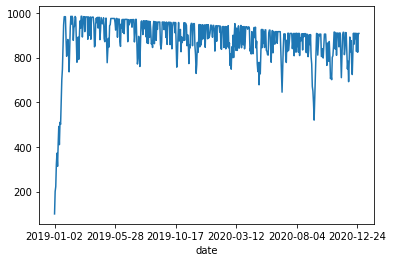

In [60]:
%matplotlib inline 

df_actions.set_index('date')['actions'].cumsum().plot();

In [61]:
# plt.subplot(211)
# ax1 = df_actions.set_index('date')['actions'].cumsum().plot()
# plt.subplot(212)
# df_account_value.set_index('date')['account_value'].cumsum().plot(sharex=ax1,color='green')

In [62]:
df_ = pd.concat([df_account_value, df_actions['actions'], trade['close']], axis=1)

In [63]:
df_['n_shares'] = df_['actions'].cumsum()
df_['v_shares'] = (df_['close'] * df_['n_shares']).round(3)

df_['d_money'] = -( df_['actions'] * df_['close'] * (1 + (2*(df_['actions']>0)-1)*0.001) ).round(3)
df_['v_money'] = 100000 + df_['d_money'].cumsum()

df_['account_value_'] = (df_['v_shares'] + df_['v_money']).round(3)

In [64]:
df_

,date,account_value,actions,close,n_shares,v_shares,d_money,v_money,account_value_
0,2019-01-02,100000.000000,100.0,98.602066,100.0,9860.207,-9870.067,90129.933,99990.140
1,2019-01-03,99627.402519,100.0,94.974693,200.0,18994.939,-9506.967,80622.966,99617.905
2,2019-01-04,100501.346212,22.0,99.391899,222.0,22065.002,-2188.808,78434.158,100499.160
3,2019-01-07,100527.302535,100.0,99.518669,322.0,32045.011,-9961.819,68472.339,100517.350
4,2019-01-08,100749.694677,50.0,100.240234,372.0,37289.367,-5017.024,63455.315,100744.682
...,...,...,...,...,...,...,...,...,...
500,2020-12-24,202443.877469,81.0,222.750000,908.0,202257.000,-18060.793,167.722,202424.722
501,2020-12-28,204432.520815,-84.0,224.960007,824.0,185367.046,18877.744,19045.466,204412.512
502,2020-12-29,203746.173613,84.0,224.149994,908.0,203528.194,-18847.428,198.038,203726.232
503,2020-12-30,201484.583905,0.0,221.679993,908.0,201285.433,-0.000,198.038,201483.471


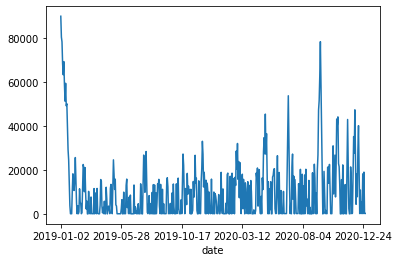

In [65]:
df_.set_index('date')['v_money'].plot();

<a id='6'></a>
# Part 7: Backtesting Performance
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [71]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.420827
Cumulative returns     1.021565
Annual volatility      0.317405
Sharpe ratio           1.268732
Calmar ratio           1.544140
Stability              0.945676
Max drawdown          -0.272532
Omega ratio            1.280132
Sortino ratio          1.849961
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.921969
Daily value at risk   -0.038391
dtype: float64


In [68]:
0.420827 / 0.317405

1.3258360769364061

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to AAPL itself buy-and-hold===========
annual return:  98.50882005689301
sharpe ratio:  1.8721562790475017
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 7)


Start date,2019-01-03
End date,2020-12-31
Total months,24
,Backtest
Annual return,85.643%
Cumulative returns,244.635%
Annual volatility,36.674%
Sharpe ratio,1.87
Calmar ratio,2.73
Stability,0.94
Max drawdown,-31.422%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.42,2020-02-12,2020-03-23,2020-06-05,83
1,20.37,2020-09-01,2020-09-18,2020-12-28,85
2,17.84,2019-05-03,2019-06-03,2019-07-31,64
3,9.24,2019-07-31,2019-08-05,2019-08-21,16
4,5.84,2020-07-20,2020-07-24,2020-07-31,10


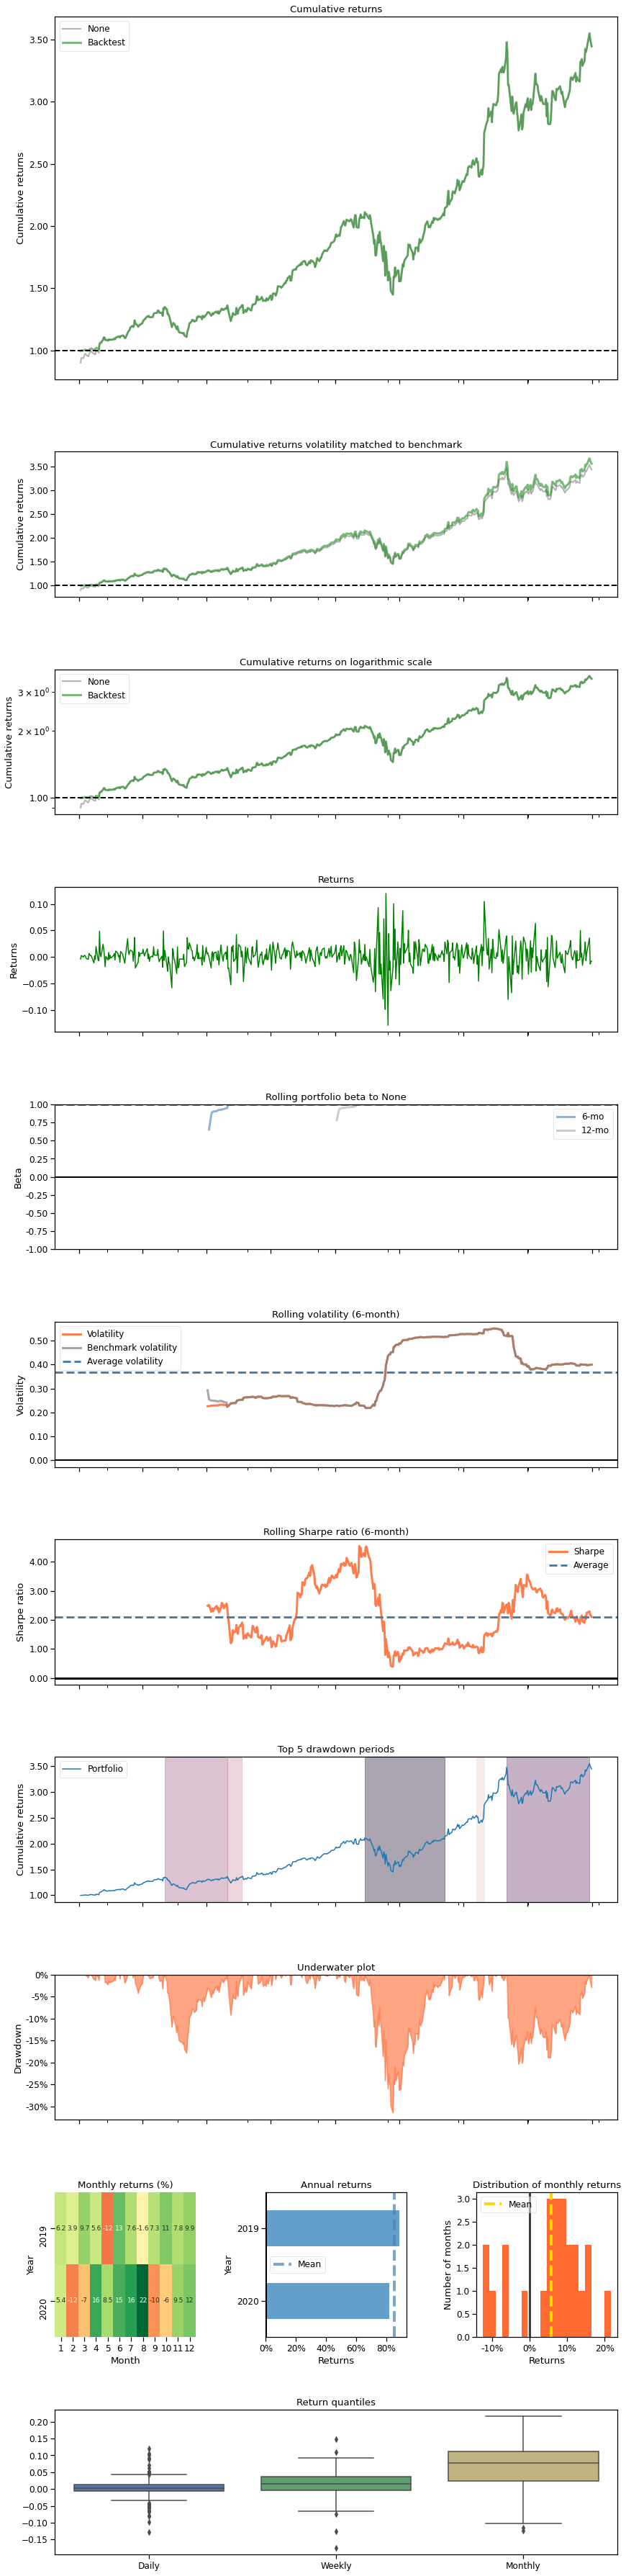

In [ ]:
print("==============Compare to AAPL itself buy-and-hold===========")
%matplotlib inline
BackTestPlot(account_value=df_account_value, 
             baseline_ticker = 'AAPL',
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [115]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('AAPL')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)
Annual return          0.800630
Cumulative returns     2.087191
Annual volatility      0.382201
Sharpe ratio           1.735128
Calmar ratio           2.547565
Stability              0.930285
Max drawdown          -0.314273
Omega ratio            1.387241
Sortino ratio          2.572655
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.081315
Daily value at risk   -0.045521
Alpha                  0.000000
Beta                   1.000000
dtype: float64


In [ ]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^GSPC')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)
Annual return          0.210804
Cumulative returns     0.442863
Annual volatility      0.264385
Sharpe ratio           0.858377
Calmar ratio           0.621384
Stability              0.467075
Max drawdown          -0.339250
Omega ratio            1.200929
Sortino ratio          1.183069
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.726400
Daily value at risk   -0.032409
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.4'></a>
## 7.4 Compare to Stock Market Index

In [114]:
print("==============Compare to S&P 500===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, baseline_ticker = '^GSPC')

==============Compare to S&P 500===========
annual return:  42.980668975921276
sharpe ratio:  1.241913303151797
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)


Start date,2019-01-03
End date,2020-11-30
Total months,22
,Backtest
Annual return,38.3%
Cumulative returns,85.9%
Annual volatility,29.2%
Sharpe ratio,1.26
Calmar ratio,1.76
Stability,0.64
Max drawdown,-21.8%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'